# Shampoo
##### *Diego Duarte 22075 -  Paula Barillas 22764*

### Análisis Exploratorio

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./data/shampoo.csv", parse_dates=True)

print("\nPrimeras 5 filas:")
print(df.head())

print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras 5 filas:
  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3

Estadísticas descriptivas:
            Sales
count   36.000000
mean   312.600000
std    148.937164
min    119.300000
25%    192.450000
50%    280.150000
75%    411.100000
max    682.000000


In [7]:

years = ['1901'] * 12 + ['1902'] * 12 + ['1903'] * 12
df['Month'] = years
df['Month'] = df['Month'] + '-' + df.index.to_series().apply(lambda i: f"{(i%12)+1:02d}")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

df.set_index('Month', inplace=True)
print(df.head())
print(df.info())

            Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes
None


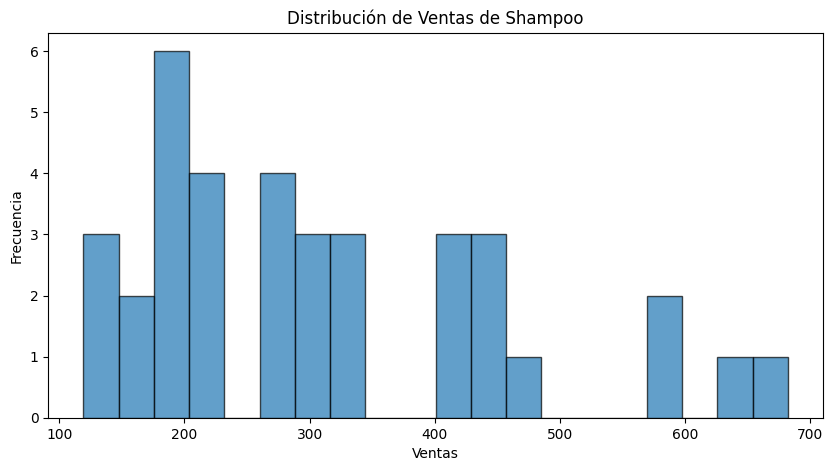

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(df['Sales'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribución de Ventas de Shampoo')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()

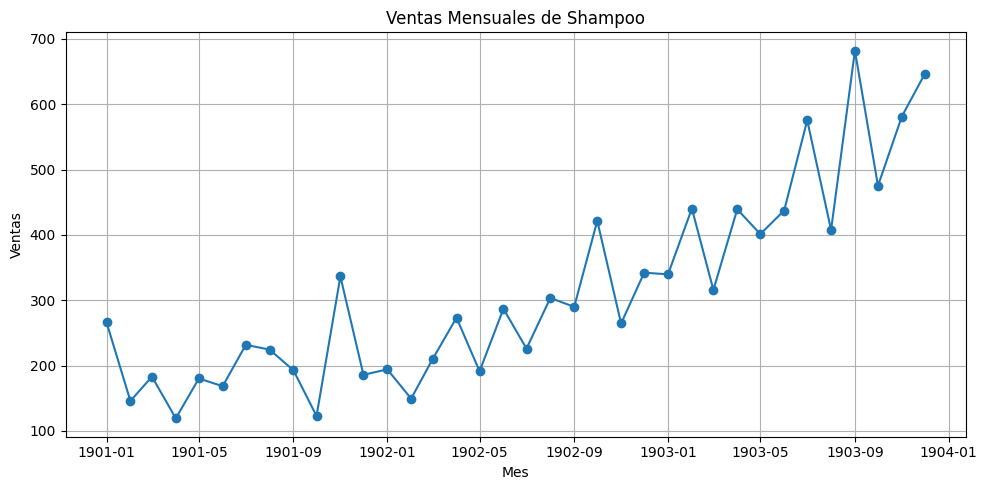

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Ventas Mensuales de Shampoo')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)
plt.tight_layout()
plt.show()

### Promedios Móviles

In [10]:
train_size = int(len(df) * 0.7)
train = df['Sales'][:train_size]
test = df['Sales'][train_size:]

print(f"Tamaño de entrenamiento: {len(train)} ")
print(f"Tamaño de prueba: {len(test)} ")

results_sales = {}

Tamaño de entrenamiento: 25 
Tamaño de prueba: 11 


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

windows = [2, 3, 6, 12]  # ventanas para datos mensuales
for window in windows:
    ma_forecast = train.rolling(window=window).mean()
    last_ma = ma_forecast.iloc[-1]
    ma_pred = [last_ma] * len(test)
    
    rmse = np.sqrt(mean_squared_error(test, ma_pred))
    mae = mean_absolute_error(test, ma_pred)
    
    results_sales[f'MA_{window}'] = {'RMSE': rmse, 'MAE': mae, 'predictions': ma_pred}
    print(f"Promedio Móvil {window} meses - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Promedio Móvil 2 meses - RMSE: 185.41, MAE: 154.74
Promedio Móvil 3 meses - RMSE: 206.61, MAE: 175.67
Promedio Móvil 6 meses - RMSE: 196.98, MAE: 166.25
Promedio Móvil 12 meses - RMSE: 242.07, MAE: 216.26


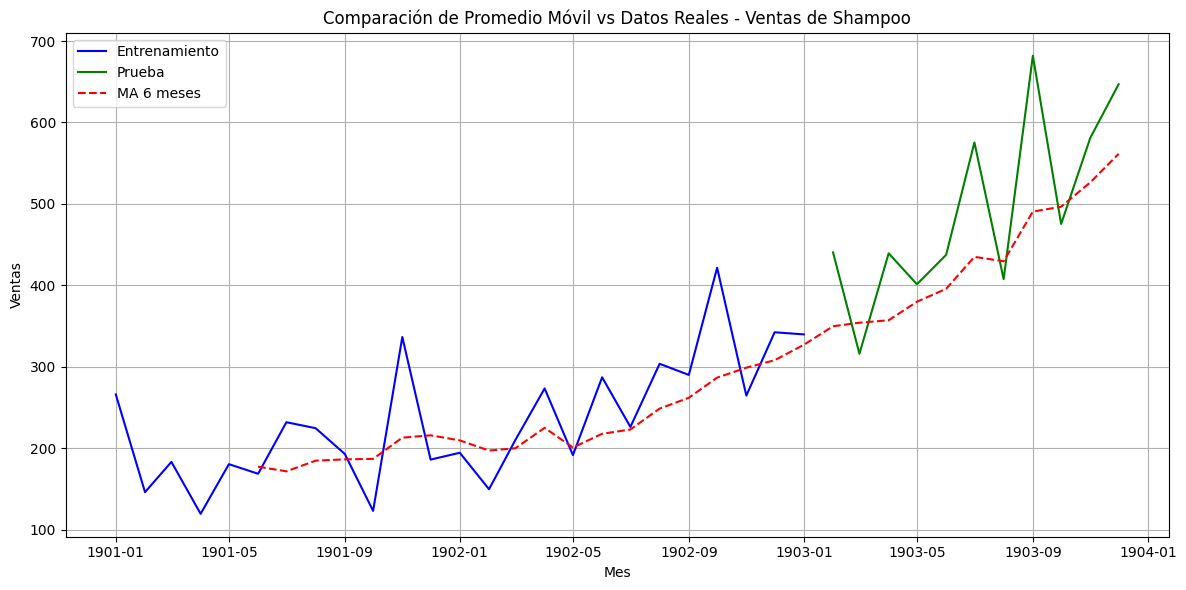

In [12]:
df['MA_6'] = df['Sales'].rolling(window=6).mean()
ma_pred = df['MA_6'].loc[test.index]

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(df.index, df['MA_6'], label='MA 6 meses', linestyle='--', color='red')

plt.title('Comparación de Promedio Móvil vs Datos Reales - Ventas de Shampoo')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Alisamiento Exponencial

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = train.asfreq('MS')  
test = test.asfreq('MS')

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
for alpha in alphas:
    model = ExponentialSmoothing(train, trend=None, seasonal=None)
    fitted_model = model.fit(smoothing_level=alpha)
    exp_pred = fitted_model.forecast(steps=len(test))
    
    rmse = np.sqrt(mean_squared_error(test, exp_pred))
    mae = mean_absolute_error(test, exp_pred)
    
    results_sales[f'EXP_{alpha}'] = {'RMSE': rmse, 'MAE': mae, 'predictions': exp_pred}
    print(f"Alisamiento Exponencial α={alpha} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Alisamiento Exponencial α=0.1 - RMSE: 248.47, MAE: 223.40
Alisamiento Exponencial α=0.3 - RMSE: 203.25, MAE: 172.36
Alisamiento Exponencial α=0.5 - RMSE: 192.48, MAE: 161.81
Alisamiento Exponencial α=0.7 - RMSE: 188.96, MAE: 158.31
Alisamiento Exponencial α=0.9 - RMSE: 186.77, MAE: 156.11


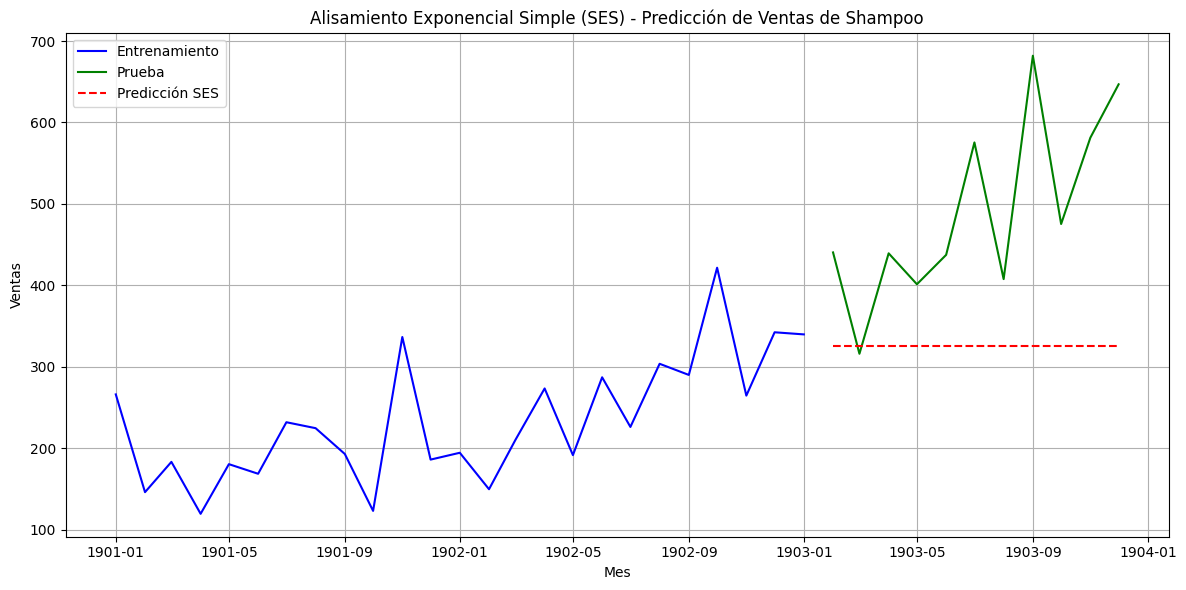

In [14]:
# Alisamiento exponencial simple
modelo = SimpleExpSmoothing(train)
modelo_ajustado = modelo.fit()

prediccion = modelo_ajustado.forecast(len(test))
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, prediccion, label='Predicción SES', color='red', linestyle='--')

plt.title("Alisamiento Exponencial Simple (SES) - Predicción de Ventas de Shampoo")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### HOLT-WINTERS

In [15]:
# Holt-Winters sin estacionalidad 
model_holt = ExponentialSmoothing(train, trend='add', seasonal=None)
fitted_holt = model_holt.fit()
holt_pred = fitted_holt.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, holt_pred))
mae = mean_absolute_error(test, holt_pred)

results_sales['HOLT'] = {'RMSE': rmse, 'MAE': mae, 'predictions': holt_pred}
print(f"Holt (tendencia lineal) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Holt-Winters con estacionalidad anual (12 meses)
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fitted_hw = model_hw.fit()
hw_pred = fitted_hw.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, hw_pred))
mae = mean_absolute_error(test, hw_pred)

results_sales['HOLT_WINTERS'] = {'RMSE': rmse, 'MAE': mae, 'predictions': hw_pred}
print(f"Holt-Winters (estacionalidad anual) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Holt (tendencia lineal) - RMSE: 160.45, MAE: 133.37
Holt-Winters (estacionalidad anual) - RMSE: 185.26, MAE: 159.25


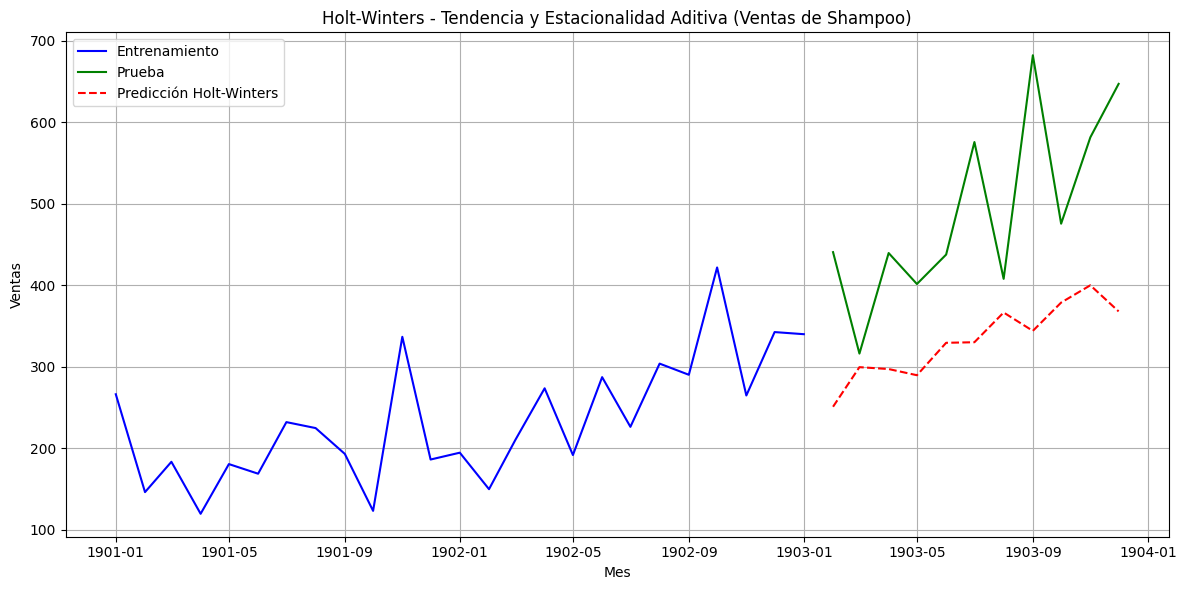

In [16]:
# visualización del modelo Holt-Winters
modelo_hw = ExponentialSmoothing(train,
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

pred_hw = modelo_hw.forecast(len(test))

# grafico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, pred_hw, label='Predicción Holt-Winters', color='red', linestyle='--')

plt.title("Holt-Winters - Tendencia y Estacionalidad Aditiva (Ventas de Shampoo)")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_arima = ARIMA(train, order=(1, 1, 1))
fitted_arima = model_arima.fit()
arima_pred = fitted_arima.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, arima_pred))
mae = mean_absolute_error(test, arima_pred)

results_sales['ARIMA'] = {'RMSE': rmse, 'MAE': mae, 'predictions': arima_pred}
print(f"ARIMA(1,1,1) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Modelo SARIMA con estacionalidad anual (12 meses)
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_sarima = model_sarima.fit()
sarima_pred = fitted_sarima.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae = mean_absolute_error(test, sarima_pred)

results_sales['SARIMA'] = {'RMSE': rmse, 'MAE': mae, 'predictions': sarima_pred}
print(f"SARIMA(1,1,1)(1,1,1,12) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

ARIMA(1,1,1) - RMSE: 194.00, MAE: 163.60


C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1,1,1)(1,1,1,12) - RMSE: 228.24, MAE: 204.79


C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


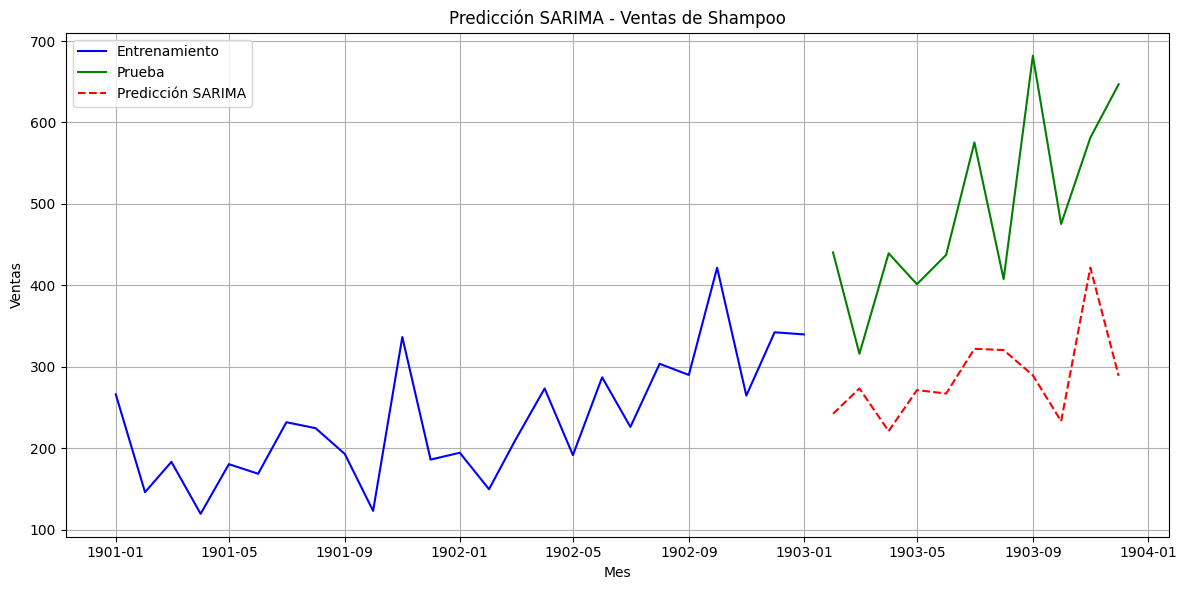

In [18]:
#modelo SARIMA
import statsmodels.api as sm

modelo_sarima = sm.tsa.statespace.SARIMAX(train,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12)).fit()

pred_sarima = modelo_sarima.predict(start=len(train),
                                    end=len(train)+len(test)-1,
                                    dynamic=False)

# grafico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, pred_sarima, label='Predicción SARIMA', color='red', linestyle='--')

plt.title("Predicción SARIMA - Ventas de Shampoo")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prophet

C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:36:33 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing


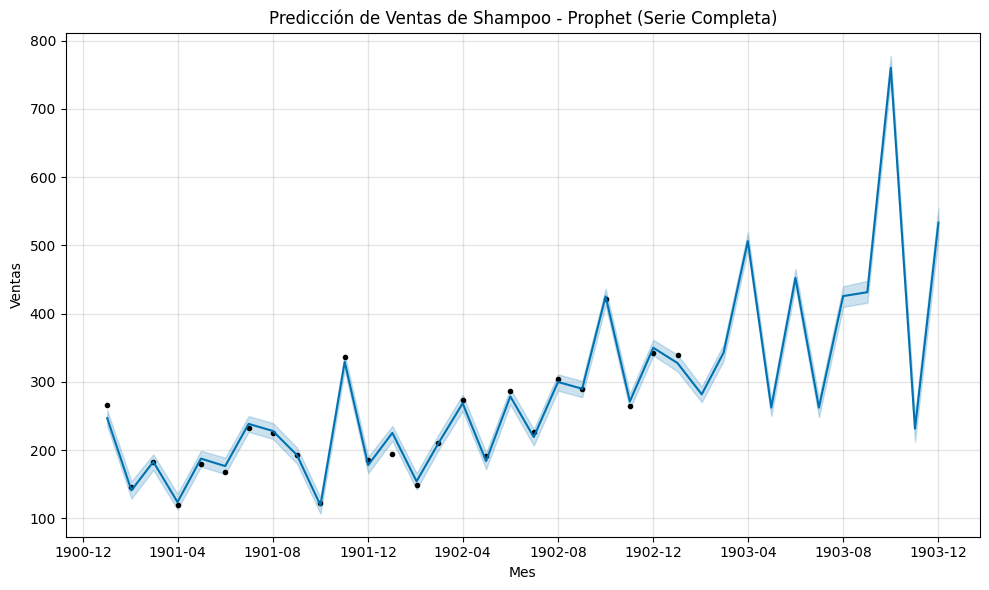

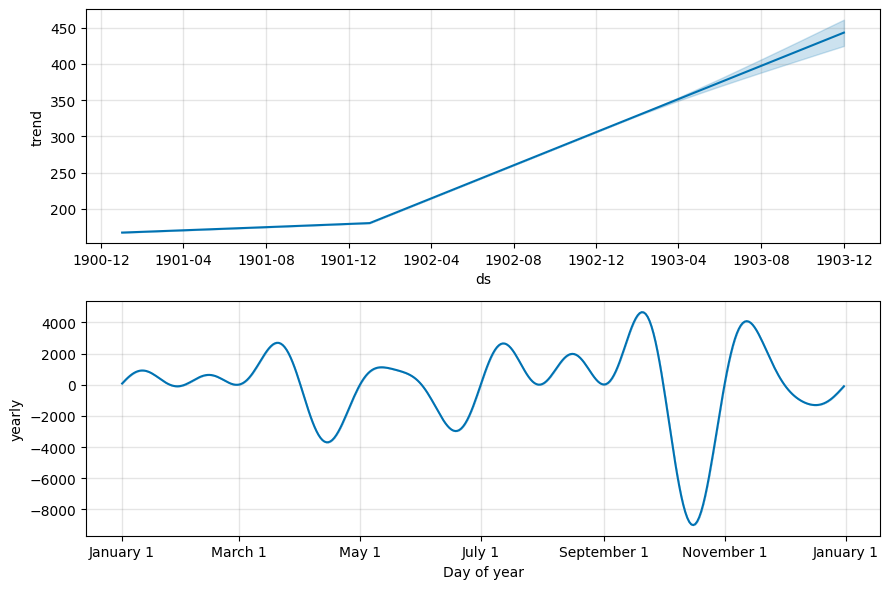

Prophet - RMSE: 197.16, MAE: 157.90


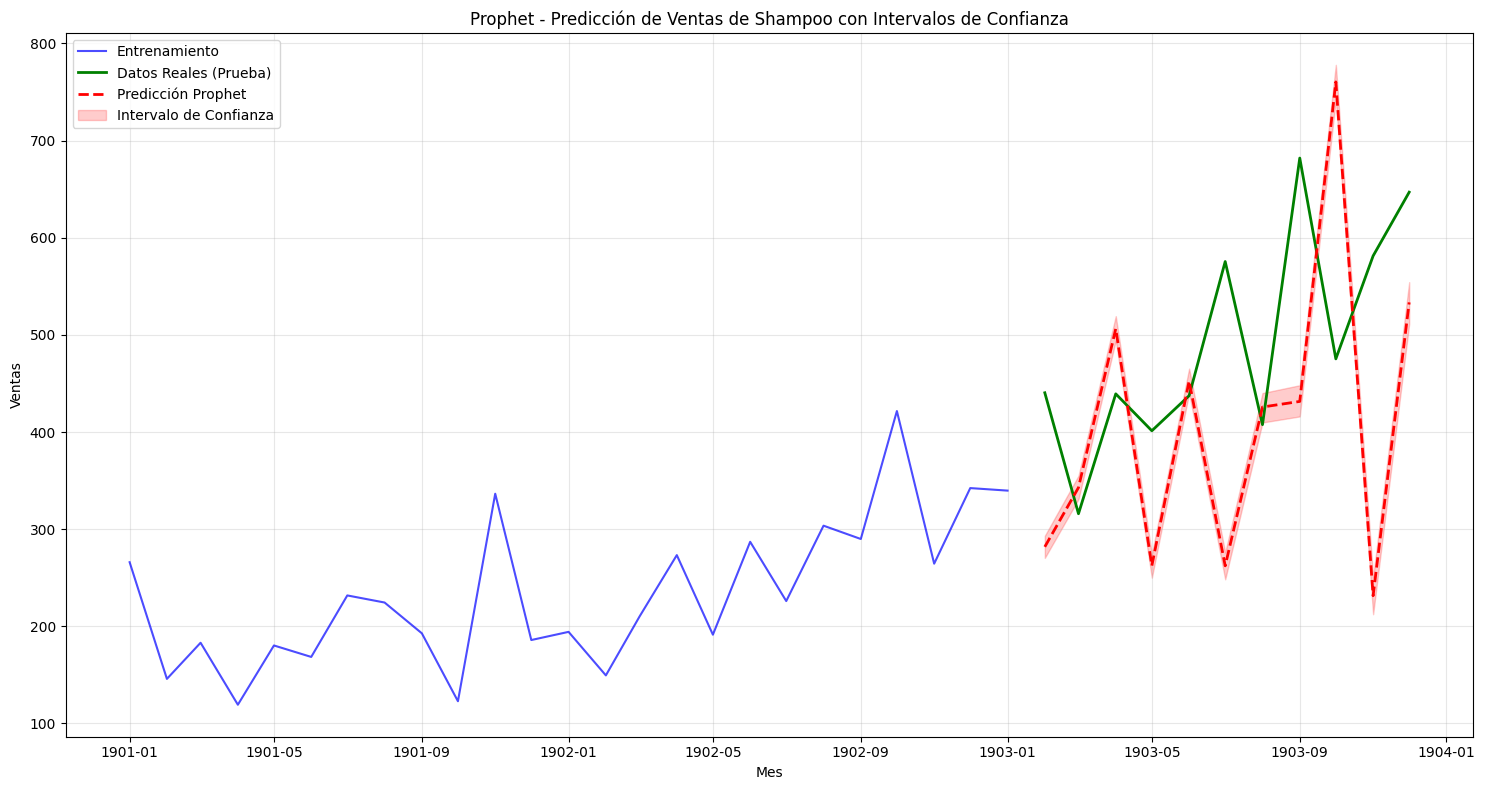

In [ ]:
from prophet import Prophet

df_prophet = pd.DataFrame()
df_prophet['ds'] = train.index
df_prophet['y'] = train.values

# modelo Prophet para datos mensuales
model_prophet = Prophet(
    daily_seasonality=False,  # No hay estacionalidad diaria en datos mensuales
    weekly_seasonality=False, # No hay estacionalidad semanal en datos mensuales
    yearly_seasonality=True,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test), freq='MS')

# Hacer predicciones
forecast = model_prophet.predict(future)

# Graficar predicciones completas
fig = model_prophet.plot(forecast)
plt.title('Predicción de Ventas de Shampoo - Prophet (Serie Completa)')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar componentes del modelo
fig = model_prophet.plot_components(forecast)
plt.tight_layout()
plt.show()

# Extraer predicciones para periodo de prueba
pred_test_prophet = forecast['yhat'].iloc[-len(test):].values

# Calcular métricas de rendimiento
rmse_prophet = np.sqrt(mean_squared_error(test, pred_test_prophet))
mae_prophet = mean_absolute_error(test, pred_test_prophet)

print(f"Prophet - RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}")
results_sales['PROPHET_FULL'] = {
    'RMSE': rmse_prophet, 
    'MAE': mae_prophet, 
    'predictions': pred_test_prophet
}

# Visualización periodo de prueba
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test.index, test, label='Datos Reales (Prueba)', color='green', linewidth=2)
plt.plot(test.index, pred_test_prophet, label='Predicción Prophet', color='red', linestyle='--', linewidth=2)

#bandas de confianza
forecast_test = forecast.iloc[-len(test):]
plt.fill_between(test.index, 
                 forecast_test['yhat_lower'].values, 
                 forecast_test['yhat_upper'].values, 
                 color='red', alpha=0.2, label='Intervalo de Confianza')

plt.title("Prophet - Predicción de Ventas de Shampoo con Intervalos de Confianza")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Comparación Modelos 

   COMPARACIÓN DE MODELOS - VENTAS Shampoo
Modelo             RMSE     MAE     
----------------------------------------
Promedios Móviles  88.58    71.79   
SES                198.48   167.71  
Holt-Winters       185.26   159.25  
SARIMA             228.24   204.79  
Prophet            197.16   157.90  


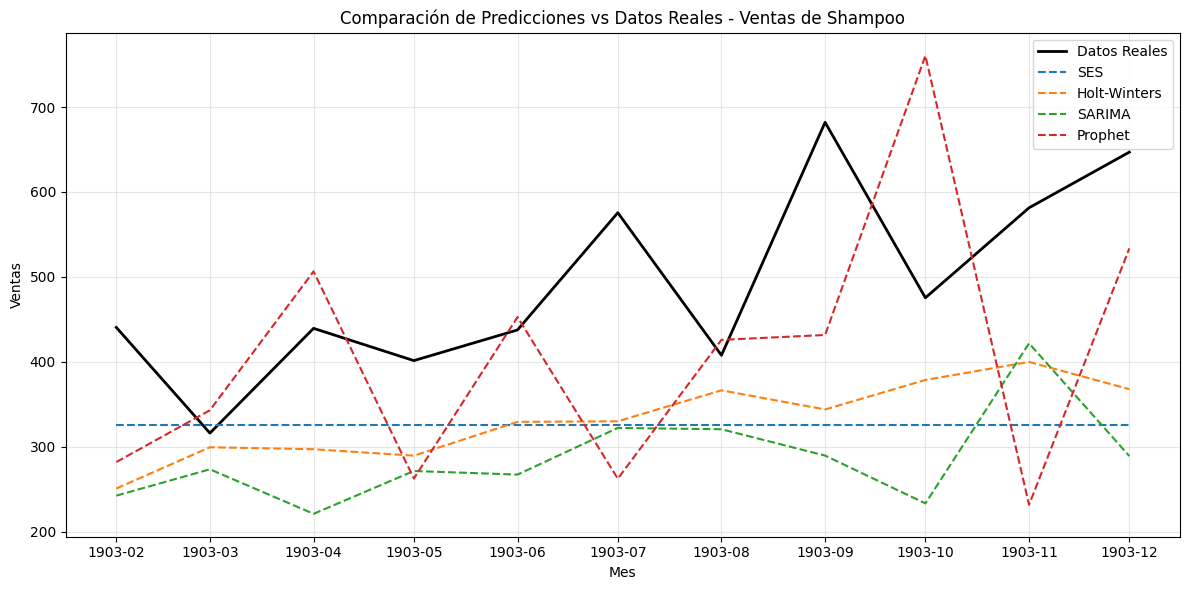

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluar(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    return rmse, mae

y_true = test

resultados = {
    'Promedios Móviles': evaluar(y_true, ma_pred),
    'SES': evaluar(y_true, modelo_ajustado.forecast(len(test))),
    'Holt-Winters': evaluar(y_true, pred_hw),
    'SARIMA': evaluar(y_true, pred_sarima),
    'Prophet': evaluar(y_true, pred_test_prophet)
}

print("=" * 40)
print("   COMPARACIÓN DE MODELOS")
print("=" * 40)
print(f"{'Modelo':<18} {'RMSE':<8} {'MAE':<8}")
print("-" * 40)
for modelo, (rmse, mae) in resultados.items():
    print(f"{modelo:<18} {rmse:<8.2f} {mae:<8.2f}")
print("=" * 40)

# Gráfico comparativo simple
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Datos Reales', color='black', linewidth=2)
plt.plot(test.index, modelo_ajustado.forecast(len(test)), label='SES', linestyle='--')
plt.plot(test.index, pred_hw, label='Holt-Winters', linestyle='--')
plt.plot(test.index, pred_sarima, label='SARIMA', linestyle='--')
plt.plot(test.index, pred_test_prophet, label='Prophet', linestyle='--')

plt.title('Comparación de Predicciones vs Datos Reales - Ventas de Shampoo')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()